# Learning Graph Structured Data on Manifolds

## Description
Recently, the embedding of Graph Structured Data (GSD) on manifolds has received considerable attention. In particular, much work has shown that hyperbolic spaces are beneficial for a wide variety of tasks with GSD. This tutorial shows how to learn such embeddings in `geomstats` using the Poincaré Ball manifold using the well-known 'Karate Club' dataset. This and several others can be found in the `datasets.data` module.

![KarateEmbedding](figures/karate_embedding_iterations.gif "segment")
*Learning a Poincaré disk embedding of the Karate club graph dataset*

## Setup


We start by importing standard tools for logging and visualization, allowing us to draw the embedding of the GSD on the manifold. Next, we import the manifold of interest, visualization tools, and other methods from `geomstats`.

In [24]:
import logging

import matplotlib.pyplot as plt

import geomstats
import geomstats.backend as gs # this should not be imported
# import geomstats.datasets.utils
import geomstats.visualization as visualization
from geomstats.datasets import graph_data_preparation as gdp
from geomstats.geometry.poincare_ball import PoincareBall


The Zachary karate club network was collected from the members of a university karate club by Wayne Zachary in 1977. Each node represents a member of the club, and each edge represents an undirected relation between two members. An often discussed problem using this dataset is to find the two groups of people into which the karate club split after an argument between two teachers.
    
Two variables are set here: the path to the graph adjacency matrix and the true labels.

In [25]:
# why do we do this and not just load the dataset for them in one function within geomstats.datasets.utils?
GRAPH_MATRIX_PATH = geomstats.datasets.utils.KARATE_PATH 
LABELS_PATH = geomstats.datasets.utils.KARATE_LABELS_PATH

## Parameters and Initialization

We define the following parameters needed for embedding:

| Parameter | Description   |
|------|------|
|   random.seed  | An initial manually set number for generating pseudorandom numbers|
| dim | Dimensions of the manifold used for embedding |
|max_epochs|Number of iterations for learning the embedding |
|lr| Learning rate|
|n_negative| Number of negative samples|
|context_size| Size of the considered context for each node of the graph|

Let us discuss a few things about the parameters of the above table.
The number of dimensions should be high (i.e., 10+) for large datasets 
(i.e., where the number of nodes/edges is significantly large). 
In this tutorial we consider a dataset that is quite small with only 34 nodes. Therefore the Poincaré disk of only two dimensions is sufficient to
capture the complexity of the graph and provide a faithful representation.
Some parameters are hard to know in advance, such as `max_epochs` and `lr`. These should be tuned specifically for each dataset.
Visualization can help with tuning the parameters. Also, one can perform a grid search to find values of these parameters which maximize some performance function. In learning embeddings, one can consider performance metrics such as
a measure for cluster seperability or normalized mutual 
information (NMI) or others.
Similarly, the number of negative samples and context size can also be thought of as hyperparameters and will
be further discussed in the sequel. An instance of the `Graph` class is created
 and set to the Karate club dataset.


In [1]:
gs.random.seed(1234)
dim = 2
max_epochs = 100
lr = .05
n_negative = 2
context_size = 1
karate_graph = gdp.Graph(graph_matrix_path=GRAPH_MATRIX_PATH,
    labels_path=LABELS_PATH)

NameError: name 'gs' is not defined

Some information abbout the dataset is displayed to provide insight into its complexity.

In [ ]:
nb_vertices_by_edges =\
    [len(e_2) for _, e_2 in karate_graph.edges.items()]
logging.info('Number of edges: %s', len(karate_graph.edges))
logging.info(
    'Mean vertices by edges: %s',
    (sum(nb_vertices_by_edges, 0) / len(karate_graph.edges)))

Denote $V$ as the set of nodes and $E \subset V\times V$ the set 
of edges. The goal of embedding GSD is to provide a faithful and exploitable representation 
of the graph structure. It is mainly achieved by preserving  *first-order* proximity 
that enforces nodes sharing edges to be close to each other. It can additionally 
preserve *second-order* proximity that enforces two nodes sharing the same context 
(i.e., nodes that are neighbours but not necessarily directly connected) to be close.
Let $\mathbb{B}^m$ be the Poincaré Ball of dimension $m$ equipped with the distance function $d$.
*first* and *second-order* proximities can be achieved by optimising the following loss functions:

## Loss function.

To preserve first and second-order proximities we adopt a loss function similar to (add cite here) and consider the negative sampling approach:

$$     \mathcal{L} = - \sum_{v_i\in V} \sum_{v_j \in C_i} \bigg[ log(\sigma(-d^2(\phi_i, \phi_j'))) + \sum_{v_k\sim \mathcal{P}_n} log(\sigma(d^2(\phi_i, \phi_k')))  \bigg]$$

where $\sigma(x)=\frac{1}{1+e^{-x}}$ is the sigmoid function and $\phi_i \in \mathbb{B}^m$ 
is the embedding of the $i$-th node of $V$, $C_i$ the nodes in the context of the 
$i$-th node, $\phi_j'\in \mathbb{B}^m$ the embedding of $v_j\in C_i$ and 
$\mathcal{P}_n$ the negative sampling distribution over $V$: 
$\mathcal{P}_n(v)=\frac{deg(v)^{3/4}}{\sum_{v_i\in V}deg(v_i)^{3/4}}$. 

We will use the following formula to optimise $L$:

$$ \phi^{t+1} = \text{Exp}_{\phi^t} \left( -lr \frac{\partial L}{\partial \phi} \right) $$

where $\phi$ is a parameter of $L$, $t\in\{1,2,\cdots\}$ is the epoch iteration number 
and $lr$ is the learning rate. The formula consists of computing the usual gradient of the loss function
which gives the direction in which the parameter should move. 
The Riemannian exponential map $\text{Exp}$ is a function that takes a base point $\phi^t$ and some 
direction vector $T$ and returns the point $\phi^{t+1}$ such $\phi^{t+1}$ belongs to the geodesic
initiated from $\phi{t}$ in the direction of $T$ and the length of the geoedesic curve between $\phi^t$ and $\phi^{t+1}$ is of length 1.

Several steps are required to implement and optimise the loss function.
Lets start first by defining the `log_sigmoid` corresponding as follows:

In [ ]:
def log_sigmoid(vector):
    """Logsigmoid function.

    Apply log sigmoid function

    Parameters
    ----------
    vector : array-like, shape=[n_samples, dim]

    Returns
    -------
    result : array-like, shape=[n_samples, dim]
    """
    return gs.log((1 / (1 + gs.exp(-vector))))

To optimise $L$ we will further need the gradient of the sigmoid function implemented as:

In [ ]:
def grad_log_sigmoid(vector):
    """Gradient of log sigmoid function.

    Parameters
    ----------
    vector : array-like, shape=[n_samples, dim]

    Returns
    -------
    gradient : array-like, shape=[n_samples, dim]
    """
    return 1 / (1 + gs.exp(vector))


Additionally the gradient of the squared distance is implemented as

In [ ]:
def grad_squared_distance(point_a, point_b):
    """Gradient of squared hyperbolic distance.

    Gradient of the squared distance based on the
    Ball representation according to point_a

    Parameters
    ----------
    point_a : array-like, shape=[n_samples, dim]
        First point in hyperbolic space.
    point_b : array-like, shape=[n_samples, dim]
        Second point in hyperbolic space.

    Returns
    -------
    dist : array-like, shape=[n_samples, 1]
        Geodesic squared distance between the two points.
    """
    hyperbolic_metric = PoincareBall(2).metric
    log_map = hyperbolic_metric.log(point_b, point_a)

    return -2 * log_map

To capture the structure of the graph, we proceed by computing the negatively sampled nodes and 
then generate random walks from each node. The latter is done via a special function within the `Graph` class.

In [28]:
negative_table_parameter = 5
negative_sampling_table = []

for i, nb_v in enumerate(nb_vertices_by_edges):
    negative_sampling_table +=\
        ([i] * int((nb_v**(3. / 4.))) * negative_table_parameter)

negative_sampling_table = gs.array(negative_sampling_table)
random_walks = karate_graph.random_walk()

NameError: name 'nb_vertices_by_edges' is not defined

Let us initialize an array that will hold the dataset embedding with random points belonging to the Poincaré disk. 

In [ ]:
embeddings = gs.random.normal(size=(karate_graph.n_nodes, dim))
embeddings = embeddings * 0.2

Then declare an instance of the `PoincareBall` manifold of two dimensions.

In [ ]:
hyperbolic_manifold = PoincareBall(2)

Optimising the loss function is performed numerically over the number of epochs. 
At each iteration, we will compute the gradient of $L$. Then the graph nodes are moved in the direction
pointed by the gradient. The movement of the nodes is performed by following geodesics in the gradient direction.
 The key to obtain an embedding representing accurately the dataset, is to move the nodes smoothly rather
than brutal movements. This is done by tuning the learning rate, such as at each epoch
all the nodes made small movements.

In [ ]:
for epoch in range(max_epochs):
    total_loss = []

Remember that we pre-computed a random walk from each node of the graph. Looking at the random walks,
 notice that nodes having many edges appear more often. Nodes appearing more often than others will therefore
 have more embedding updates. This is one of the main reasons why random walks have proven to be effective
 for capturing the graph structure and use nodes along these walks for optimizing $L$.

In [ ]:
    for path in random_walks:

        for example_index, one_path in enumerate(path):
            context_index = path[max(0, example_index - context_size):
                                 min(example_index + context_size,
                                 len(path))]
            negative_index =\
                gs.random.randint(negative_sampling_table.shape[0],
                                  size=(len(context_index),
                                  n_negative))
            negative_index = negative_sampling_table[negative_index]

            example_embedding = embeddings[one_path]

Given the embedding of each node, context and negative sample, we compute the gradient of the loss function
for the specific node and the value of the loss.

In [ ]:
            for one_context_i, one_negative_i in zip(context_index,
                                                         negative_index):
                    context_embedding = embeddings[one_context_i]
                    negative_embedding = embeddings[one_negative_i]
                    l, g_ex = loss(
                        example_embedding,
                        context_embedding,
                        negative_embedding,
                        hyperbolic_manifold)
                    total_loss.append(l)

                    example_to_update = embeddings[one_path]
                    embeddings[one_path] = hyperbolic_manifold.metric.exp(
                        -lr * g_ex, example_to_update)

        logging.info(
            'iteration %d loss_value %f',
            epoch, sum(total_loss, 0) / len(total_loss))


## Plotting results


NameError: name 'embeddings' is not defined

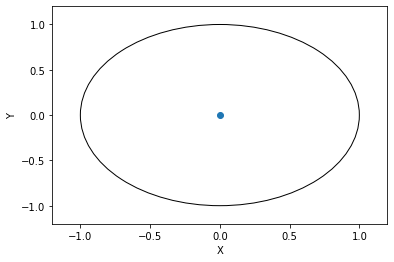

In [27]:
colors = {1: 'b', 2: 'r'}
circle = visualization.PoincareDisk(point_type='ball')
plt.figure()
ax = plt.subplot(111)
circle.add_points(gs.array([[0, 0]]))
circle.set_ax(ax)
circle.draw(ax=ax)
for i_embedding, embedding in enumerate(embeddings):
    plt.scatter(
        embedding[0], embedding[1],
        c=colors[karate_graph.labels[i_embedding][0]])
plt.show()

In [ ]:
def loss(example_embedding, context_embedding, negative_embedding,
         manifold):
    """Compute loss and grad.

    Compute loss and grad given embedding of the current example,
    embedding of the context and negative sampling embedding.
    """
    n_edges, dim =\
        negative_embedding.shape[0], example_embedding.shape[-1]
    example_embedding = gs.expand_dims(example_embedding, 0)
    context_embedding = gs.expand_dims(context_embedding, 0)

We compute the distance between each embedded node and its context


In [ ]:
    positive_distance =\
        manifold.metric.squared_dist(
            example_embedding, context_embedding)
    positive_loss =\
        log_sigmoid(-positive_distance)

    reshaped_example_embedding =\
        gs.repeat(example_embedding, n_edges, axis=0)

Similarly, compute the squared distances between embedding of each node and its negative samples

In [ ]:
    negative_distance =\
        manifold.metric.squared_dist(
            reshaped_example_embedding, negative_embedding)
    negative_loss = log_sigmoid(negative_distance)

    total_loss = -(positive_loss + negative_loss.sum())

    positive_log_sigmoid_grad =\
        -grad_log_sigmoid(-positive_distance)

    positive_distance_grad =\
        grad_squared_distance(example_embedding, context_embedding)

    positive_grad =\
        gs.repeat(positive_log_sigmoid_grad, dim, axis=-1)\
        * positive_distance_grad

    negative_distance_grad =\
        grad_squared_distance(reshaped_example_embedding, negative_embedding)

    negative_distance = gs.to_ndarray(negative_distance,
                                      to_ndim=2, axis=-1)
    negative_log_sigmoid_grad =\
        grad_log_sigmoid(negative_distance)

    negative_grad = negative_log_sigmoid_grad\
        * negative_distance_grad

Finally the gradient of $L$ at the current node embedding is obtained and returned as

In [ ]:
    example_grad = -(positive_grad + negative_grad.sum(axis=0))

    return total_loss, example_grad


<div class="cite2c-biblio"></div>